In [2]:
#Import numpy
import numpy as np

#Import scikitlearn for machine learning functionalities
import sklearn
from sklearn.manifold import TSNE
from sklearn.datasets import load_digits # For the UCI ML handwritten digits dataset

# Import matplotlib for plotting graphs ans seaborn for attractive graphics.
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
%matplotlib inline

import seaborn as sb

import importlib
import os
os.environ['CUDA_VISIBLE_DEVICES']='0,1,2,3'

import argparse
import datetime
import json
import random
import time
from pathlib import Path

import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
import datasets
import datasets.DAOD as DAOD
import util.misc as utils
import datasets.samplers as samplers
from datasets import build_dataset, get_coco_api_from_dataset
from engine import evaluate, train_one_epoch
import models
from models import build_model

from config import get_cfg_defaults
from tqdm import tqdm

import util.misc as utils

In [3]:
importlib.reload(models) # reload folder

<module 'models' from '/scratch2/users/cku/adaptation/AQT_subset/models/__init__.py'>

##  config set up

In [4]:
# best way is to modify all args to manual parameter

def setup(config_file):
    # initialise cfg from both defualt and the one defined by file
    cfg = get_cfg_defaults()
    
    if config_file:
        cfg.merge_from_file(config_file)
#     if opts:
#         cfg.merge_from_list(args.opts)
    utils.init_distributed_mode(cfg)
    cfg.freeze()
    
    # copy scripts to a specified dest
    if cfg.OUTPUT_DIR:
        Path(cfg.OUTPUT_DIR).mkdir(parents=True, exist_ok=True)
        os.system(f'cp {config_file} {cfg.OUTPUT_DIR}')
        ddetr_src = 'models/deformable_detr.py'
        ddetr_des = Path(cfg.OUTPUT_DIR) / 'deformable_detr.py.backup'
        dtrans_src = 'models/deformable_transformer.py'
        dtrans_des = Path(cfg.OUTPUT_DIR) / 'deformable_transformer.py.backup'
        main_src = 'main.py'
        main_des = Path(cfg.OUTPUT_DIR) / 'main.py.backup'
        os.system(f'cp {ddetr_src} {ddetr_des}')
        os.system(f'cp {dtrans_src} {dtrans_des}')
        os.system(f'cp {main_src} {main_des}')

    return cfg

# write a name matching function, if names match named_params 
def match_name_keywords(n, name_keywords):
    out = False
    for b in name_keywords:
        if b in n:
            out = True
            break
    return out

In [5]:
# config_file = 'configs/r50_uda_c2fc.yaml'
config_file = 'configs/debug_mode.yaml'

## load config file

In [6]:
cfg = setup(config_file)
# device
device = torch.device(cfg.DEVICE)

# fix the seed for reproducibility
seed = cfg.SEED + utils.get_rank()
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

Not using distributed mode


In [7]:
cfg.DIST.DISTRIBUTED, cfg.DIST.DIST_BACKEND, cfg.DIST.GPU, cfg.DIST.WORLD_SIZE

(False, 'nccl', 0, 4)

In [8]:
torch.cuda.current_device()

0

In [9]:
cfg.DEBUG # check debug mode

True

In [10]:
cfg.TRAIN.BATCH_SIZE, cfg.DATASET.NUM_CLASSES

(2, 9)

## build model

In [11]:
# build model and send it to cuda device
model, criterion, postprocessors, postprocessors_target = build_model(cfg)

# cannot set multiple devices at once, can only specify multiple devices when calling data parallel or distributed data parallel
model.to(device) 
model_without_ddp = model
# model=torch.nn.parallel.DistributedDataParallel(model, device_ids=[0])

n_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)

/scratch2/users/cku/anaconda3/envs/deformable_detr/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/scratch2/users/cku/anaconda3/envs/deformable_detr/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [12]:
for n, p in model.named_parameters():
    if match_name_keywords(n, ['backbone']):
        print(n)

backbone.0.backbone.conv1.weight
backbone.0.backbone.layer1.0.conv1.weight
backbone.0.backbone.layer1.0.conv2.weight
backbone.0.backbone.layer1.0.conv3.weight
backbone.0.backbone.layer1.0.downsample.0.weight
backbone.0.backbone.layer1.1.conv1.weight
backbone.0.backbone.layer1.1.conv2.weight
backbone.0.backbone.layer1.1.conv3.weight
backbone.0.backbone.layer1.2.conv1.weight
backbone.0.backbone.layer1.2.conv2.weight
backbone.0.backbone.layer1.2.conv3.weight
backbone.0.backbone.layer2.0.conv1.weight
backbone.0.backbone.layer2.0.conv2.weight
backbone.0.backbone.layer2.0.conv3.weight
backbone.0.backbone.layer2.0.downsample.0.weight
backbone.0.backbone.layer2.1.conv1.weight
backbone.0.backbone.layer2.1.conv2.weight
backbone.0.backbone.layer2.1.conv3.weight
backbone.0.backbone.layer2.2.conv1.weight
backbone.0.backbone.layer2.2.conv2.weight
backbone.0.backbone.layer2.2.conv3.weight
backbone.0.backbone.layer2.3.conv1.weight
backbone.0.backbone.layer2.3.conv2.weight
backbone.0.backbone.layer2.3.

## build data loader

In [13]:
# build coco detection dataset
dataset_val = build_dataset(image_set='val', cfg=cfg)

if cfg.DIST.DISTRIBUTED:
    if cfg.CACHE_MODE:
        sampler_val = samplers.NodeDistributedSampler(dataset_val, shuffle=False)
    else:
        sampler_val = samplers.DistributedSampler(dataset_val, shuffle=False)
else:
    sampler_val = torch.utils.data.SequentialSampler(dataset_val)
    
# the valid dataloder uses a sequential sampler
data_loader_val = DataLoader(dataset_val, cfg.TRAIN.BATCH_SIZE, sampler=sampler_val,
                             drop_last=False, collate_fn=utils.collate_fn, num_workers=cfg.NUM_WORKERS,
                             pin_memory=True)

loading annotations into memory...
Done (t=0.95s)
creating index...
index created!


## model paths

In [17]:
model_path = '/scratch2/users/cku/adaptation/AQT_subset/exps/test_15_epoch/checkpoint0099.pth'
# model_path = '/scratch2/users/cku/adaptation/AQT_subset/exps/pretrain_AQT/checkpoint0099.pth'

In [18]:
# load model weights
checkpoint = torch.load(model_path, map_location='cpu')
model_without_ddp.load_state_dict(checkpoint['model'], strict=False)

_IncompatibleKeys(missing_keys=['cross_attn_enc.cross_attn.in_proj_weight', 'cross_attn_enc.cross_attn.in_proj_bias', 'cross_attn_enc.cross_attn.out_proj.weight', 'cross_attn_enc.cross_attn.out_proj.bias', 'cross_attn_enc.norm1.weight', 'cross_attn_enc.norm1.bias', 'cross_attn_enc.linear.weight', 'cross_attn_enc.linear.bias', 'cross_attn_enc.norm2.weight', 'cross_attn_enc.norm2.bias'], unexpected_keys=['cross_attn.cross_attn.in_proj_weight', 'cross_attn.cross_attn.in_proj_bias', 'cross_attn.cross_attn.out_proj.weight', 'cross_attn.cross_attn.out_proj.bias', 'cross_attn.norm1.weight', 'cross_attn.norm1.bias', 'cross_attn.linear.weight', 'cross_attn.linear.bias', 'cross_attn.norm2.weight', 'cross_attn.norm2.bias'])

## decoder embeddings

In [19]:
# get batch index and query index
def _get_src_permutation_idx(indices):
    # permute predictions following indices
    batch_idx = torch.cat([torch.full_like(src, i) for i, (src, _) in enumerate(indices)])
    src_idx = torch.cat([src for (src, _) in indices])
    return batch_idx, src_idx

def _get_tgt_permutation_idx(indices):
    # permute targets following indices
    batch_idx = torch.cat([torch.full_like(tgt, i) for i, (_, tgt) in enumerate(indices)])
    tgt_idx = torch.cat([tgt for (_, tgt) in indices])
    return batch_idx, tgt_idx

In [20]:
num_classes = 9

"""[{'id': 1, 'name': 'person'},
 {'id': 2, 'name': 'car'},
 {'id': 3, 'name': 'train'},
 {'id': 4, 'name': 'rider'},
 {'id': 5, 'name': 'truck'},
 {'id': 6, 'name': 'motorcycle'},
 {'id': 7, 'name': 'bicycle'},
 {'id': 8, 'name': 'bus'}]"""

"[{'id': 1, 'name': 'person'},\n {'id': 2, 'name': 'car'},\n {'id': 3, 'name': 'train'},\n {'id': 4, 'name': 'rider'},\n {'id': 5, 'name': 'truck'},\n {'id': 6, 'name': 'motorcycle'},\n {'id': 7, 'name': 'bicycle'},\n {'id': 8, 'name': 'bus'}]"

## tsne for decoder embeddings in the target domain only (bs=2)

In [21]:
# choose to capture outputs at train or test mode
# model.eval() # set to eval mode to get both source and target labels
model.eval()

DeformableDETR(
  (memory): Memory_source()
  (cross_attn_enc): CrossAttention_agg_prototypes(
    (grl): GradientReversal()
    (cross_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
    )
    (dropout1): Dropout(p=0.1, inplace=False)
    (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (linear): Linear(in_features=256, out_features=256, bias=True)
    (dropout2): Dropout(p=0.1, inplace=False)
    (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  )
  (transformer): DeformableTransformer(
    (encoder): DeformableTransformerEncoder(
      (layers): ModuleList(
        (0): DeformableTransformerEncoderLayer(
          (space_attn): DomainAttention(
            (grl): GradientReversal()
            (cross_attn): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
            )
            (dropout1): Dropout(p=

In [24]:
# model.eval() # set to eval mode to get both source and target labels

cur_iter_num = 0
total_iter_num = 0 
# length of dataloader is 250
target_features_1 = []
target_features_2 = []
target_features_new = []
tgt_label_1 = []
tgt_label_2 = []
tgt_label_new = []

boxes = []

# data and labels for inference
for samples, targets in tqdm(data_loader_val, desc='running inference'):
    samples = samples.to(device)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    outputs = model(samples, targets, cur_iter_num, total_iter_num) # in debug mode, outputs would be a tuple
    
    out, features, memory, hs = outputs


    loss_dict, indices = criterion(out, targets)
    
    # get matched query gt indices
    # two sets of indices for train mode
    idx_1 = _get_src_permutation_idx(indices) # get batch and permuted query position
    
    # target_classes: (2,300,9)
    target_classes = torch.full((2,300), num_classes,
                                dtype=torch.int64, device=out['pred_logits'].device)

    
    # all class labels across all samples within a batch
    target_classes_o = torch.cat([t["labels"][J] for t, (_, J) in zip(targets, indices)])
    
    target_classes[idx_1] = target_classes_o

    # torch.Size([300])
    # for eval mode, only target data is loaded
    target_label_1 = target_classes[0]
    
    # exclude background
    tgt_query_pos_1 = torch.where(target_label_1!=num_classes)
    
    # get correponding labels for each non-background query
    target_gt_1 = target_label_1[tgt_query_pos_1[0]]
    
    # you may visualise subset of classes here by excluding the classes
#     target_gt_1_idx = torch.where(target_gt_1!=1)
#     target_gt_1_new = target_gt_1[target_gt_1_idx]
#     import pdb; pdb.set_trace()
    
    # get src query embeddings
    target_out_1 = torch.index_select(hs[-1][0], 0, tgt_query_pos_1[0]) #tgt_query_pos_1 is a tuple, thus need to index element
#     target_gt_1 = torch.index_select(hs[-1][0], 0, target_gt_1_idx[0])
#     target_gt_1 = torch.index_select(, 0, target_gt_1[0])
#     import pdb; pdb.set_trace()

    # store 
    target_features_1.extend(target_out_1.cpu().detach().numpy())
    target_features_new.extend(target_gt_1.cpu().detach().numpy())
    
    
    # accumulate for all samples
    tgt_label_1.extend(target_gt_1.cpu().detach().numpy())
#     tgt_label_new.extend(target_gt_1_new.cpu().detach().numpy())
    
    # target boxes
#     boxes.append(rescaled_boxes[1].cpu().detach().numpy())

target_features_1 = np.stack(target_features_1) # source features
# target_features_new = np.stack(target_features_new)
tgt_label_1 = np.stack(tgt_label_1)
# tgt_label_new = np.stack(tgt_label_new)

running inference:   0%|                                                       | 0/250 [00:00<?, ?it/s]/scratch2/users/cku/adaptation/AQT_subset/models/deformable_detr_contrastive_bak.py:755: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  card_err = F.l1_loss(card_pred.float(), tgt_lengths.float())
running inference: 100%|█████████████████████████████████████████████| 250/250 [00:42<00:00,  5.91it/s]


In [ ]:
tgt_label_1.shape

In [ ]:
# obtained features and labels
target_features_1.shape

In [ ]:
from itertools import groupby

# check lengths
sum([len(list(group)) for key, group in groupby(sorted(tgt_label_1))])
len([len(list(group)) for key, group in groupby(sorted(tgt_label_1))])
len(target_features_1), len(tgt_label_1)

In [ ]:
# from itertools import groupby

# number_samples= np.sort([len(list(group)) for key, group in groupby(sorted(tgt_label_1))])[1]

# # mutable, so write in different loops
# new_tgt_label_1 = []
# for key, group in groupby(sorted(tgt_label_1)):
# #     print(list(group)[:number_samples])
# #     length = len(list(group))
# #     new_target_features_1.extend(target_features_1[:length][:number_samples])
#     new_tgt_label_1.extend(list(group)[:number_samples])

# # new_tgt_label_1 = []
# new_target_features_1 = []
# for key, group in groupby(sorted(tgt_label_1)):
# #     print(list(group)[:number_samples])
#     length = len(list(group))
#     new_target_features_1.extend(target_features_1[:length][:number_samples])
# #     new_tgt_label_1.extend(list(group)[:number_samples])

# new_target_features_1 = torch.as_tensor(new_target_features_1)
# new_tgt_label_1 = torch.as_tensor(new_tgt_label_1)

In [28]:
# merge prototypes into tsne features
# target_features_1 = torch.cat([source_features, prototypes[0]])
# target_features_2 = torch.cat([target_features, prototypes[1]])

In [25]:
# train tsne
# tsne_tgt_new = TSNE(n_components=2).fit_transform(new_target_features_1)
tsne_tgt_new = TSNE(n_components=2).fit_transform(target_features_1)

/scratch2/users/cku/anaconda3/envs/deformable_detr/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/scratch2/users/cku/anaconda3/envs/deformable_detr/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [26]:
# scale and move the coordinates so they fit [0; 1] range

def scale_to_01_range(x):

    # compute the distribution range
    value_range = (np.max(x) - np.min(x))

   # move the distribution so that it starts from zero
   # by extracting the minimal value from all its values
    starts_from_zero = x - np.min(x)
    # make the distribution fit [0; 1] by dividing by its range

    return starts_from_zero / value_range

## tsne on tgt query embeddings

In [43]:
tsne_tgt_new.shape

(4954, 2)

In [27]:
# get values for x and y
tx_tgt = tsne_tgt_new[:, 0]
ty_tgt = tsne_tgt_new[:, 1]

# scale to range between 0 and 1
tx_tgt = scale_to_01_range(tx_tgt)
ty_tgt = scale_to_01_range(ty_tgt)

## baseline

In [ ]:
# from itertools import groupby

# number_samples= np.sort([len(list(group)) for key, group in groupby(sorted(tgt_label_1))])[1]

# # mutable, so write in different loops
# new_tgt_label_1 = []
# for key, group in groupby(sorted(tgt_label_1)):
# #     print(list(group)[:number_samples])
# #     length = len(list(group))
# #     new_target_features_1.extend(target_features_1[:length][:number_samples])
#     new_tgt_label_1.extend(list(group)[:number_samples])

# # new_tgt_label_1 = []
# new_target_features_1 = []
# for key, group in groupby(sorted(tgt_label_1)):
# #     print(list(group)[:number_samples])
#     length = len(list(group))
#     new_target_features_1.extend(target_features_1[:length][:number_samples])
# #     new_tgt_label_1.extend(list(group)[:number_samples])

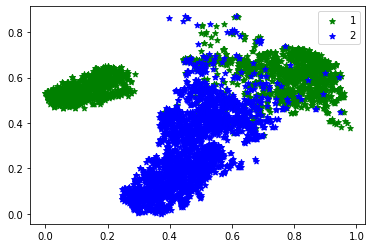

In [47]:
# define an extra label for prototype tokens
# colors_per_class = {'0': 'r', '1': 'g', '2': 'b',
#           '3':'c', '4': 'm', '5': 'y',
#                     '6':'k', '7':'pink', '8':'w'}


colors_per_class = {'1': 'g', '2': 'b'}

# fir distinuishing decoder embeddings and prototypes 
marker = ['*']

# need to use a different marker for prototype tokens

# labels = []

# need to know what labels are assigned to each feature in order to plot them
fig = plt.figure()
ax = fig.add_subplot(111)

# plot a cluster one by one
for label in colors_per_class:

    indices = [i for i, l in enumerate(tgt_label_1) if l == int(label)]
    # use the indices of the current label to index the corresponding feature embeddings
    current_tx = np.take(tx_tgt, indices)
    current_ty = np.take(ty_tgt, indices)

    # add a scatter plot with the corresponding color and label
    ax.scatter(current_tx, current_ty, marker=marker[0], c=colors_per_class[label], label=label)
        
    
# build a legend using the labels we set previously
ax.legend(loc='best')
# finally, show the plot
plt.show()

## contrastive learning

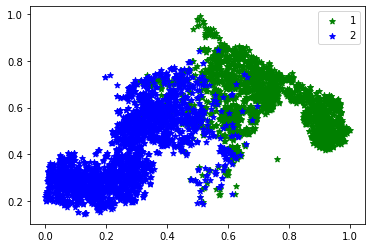

In [28]:
# define an extra label for prototype tokens
# colors_per_class = {'0': 'r', '1': 'g', '2': 'b',
#           '3':'c', '4': 'm', '5': 'y',
#                     '6':'k', '7':'pink', '8':'w'}


colors_per_class = {'1': 'g', '2': 'b'}

# fir distinuishing decoder embeddings and prototypes 
marker = ['*']

# need to use a different marker for prototype tokens

# labels = []

# need to know what labels are assigned to each feature in order to plot them
fig = plt.figure()
ax = fig.add_subplot(111)

# plot a cluster one by one
for label in colors_per_class:

    indices = [i for i, l in enumerate(tgt_label_1) if l == int(label)]
    # use the indices of the current label to index the corresponding feature embeddings
    current_tx = np.take(tx_tgt, indices)
    current_ty = np.take(ty_tgt, indices)

    # add a scatter plot with the corresponding color and label
    ax.scatter(current_tx, current_ty, marker=marker[0], c=colors_per_class[label], label=label)
        
    
# build a legend using the labels we set previously
ax.legend(loc='best')
# finally, show the plot
plt.show()

In [71]:
tgt_label_1.shape, tgt_label_2.shape

((2326,), (2317,))

## plot memory embeddings

In [ ]:
# scale and move the coordinates so they fit [0; 1] range

def scale_to_01_range(x):

    # compute the distribution range
    value_range = (np.max(x) - np.min(x))

   # move the distribution so that it starts from zero
   # by extracting the minimal value from all its values
    starts_from_zero = x - np.min(x)
    # make the distribution fit [0; 1] by dividing by its range

    return starts_from_zero / value_range

In [ ]:
# w/o positional update
embeddings = torch.load('exps/200epochs/r50_uda_multi_scale_multi_layer_memory_size_40/keys0169.pt')
embeddings_np = embeddings.cpu().numpy()
# perplexity: how to balance between local/global aspects of your data
# it is also about the number of close neighbors each point has
tsne = TSNE(n_components=2, perplexity=2).fit_transform(embeddings_np)

tx = tsne[:, 0]
ty = tsne[:, 1]
tx = scale_to_01_range(tx)
ty = scale_to_01_range(ty)

# need to know what labels are assigned to each feature in order to plot them
fig = plt.figure()
ax = fig.add_subplot(111)

# add a scatter plot with the corresponding color and label
ax.scatter(tx, ty)
plt.show()

In [ ]:
# w/o positional update
embeddings = torch.load('exps/200epochs/r50_uda_multi_scale_multi_layer_memory_partitioned/keys0169.pt')
embeddings_np = embeddings.cpu().numpy()
# perplexity: how to balance between local/global aspects of your data
# it is also about the number of close neighbors each point has
tsne = TSNE(n_components=2, perplexity=2).fit_transform(embeddings_np)

tx = tsne[:, 0]
ty = tsne[:, 1]
tx = scale_to_01_range(tx)
ty = scale_to_01_range(ty)

# need to know what labels are assigned to each feature in order to plot them
fig = plt.figure()
ax = fig.add_subplot(111)

# add a scatter plot with the corresponding color and label
ax.scatter(tx, ty)
plt.show()

In [ ]:
# colors_per_class = {'1': np.array([0.000, 0.447, 0.741]), '2': [0.850, 0.325, 0.098], '3': [0.929, 0.694, 0.125],
#           '4': [0.494, 0.184, 0.556], '5': [0.466, 0.674, 0.188], '6': [0.301, 0.745, 0.933],
#                     '7':[0.453, 0.233, 0.763], '8':[0.333, 0.674, 0.000]}


colors_per_class = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'pink', 'orange']



# supposedly this list should indicate the class id for each sample, but here we have a set
labels = ['1','2','3','4','5','6','7','8']